# Preparing Part

Important imports and array handling and plotting

In [3]:
%matplotlib inline

In [42]:
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

import os
os.environ['TP_CPP_MIN_LOG_LEVEL']='3'

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.optimizers import SGD

Loading dataset and splitting it into train and test sets

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Plotting some examples

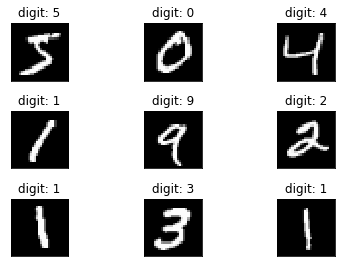

In [6]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
fig

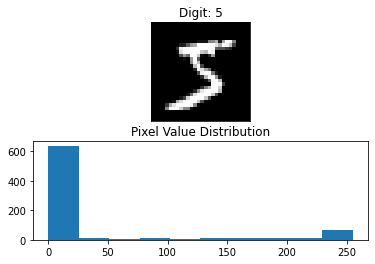

In [7]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Value Distribution")
fig

In [8]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


In [9]:
# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [10]:
# normalizing the data to help with the training
X_train /= 255
X_test /= 255

In [11]:
# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


In [12]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


In [37]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_test.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (10000, 10)


# Experimenting Part

In [56]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

### Comparing the Training Optimization Algorithm

In [59]:
# building a linear stack of layers with the sequential model
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
	# create model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model
# create model
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=128, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.980117 using {'optimizer': 'Adadelta'}
0.942450 (0.002757) with: {'optimizer': 'SGD'}
0.978683 (0.001215) with: {'optimizer': 'RMSprop'}
0.979400 (0.000909) with: {'optimizer': 'Adagrad'}
0.980117 (0.000377) with: {'optimizer': 'Adadelta'}
0.978117 (0.000754) with: {'optimizer': 'Adam'}
0.979517 (0.001348) with: {'optimizer': 'Adamax'}
0.978083 (0.000579) with: {'optimizer': 'Nadam'}


The results suggest that the "Adadelta" optimization algorithm is the best with a score of "98%" accuracy.

### Comparing Batch Size and Number of Epochs

In [60]:
def create_model1():
	# create model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adadelta')
    
    return model

# create model
model = KerasClassifier(build_fn=create_model1, verbose=0)
# define the grid search parameters
batch_size = [32, 64, 128]
epochs = [10, 20, 25]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.980800 using {'batch_size': 128, 'epochs': 25}
0.978567 (0.000531) with: {'batch_size': 32, 'epochs': 10}
0.980100 (0.000722) with: {'batch_size': 32, 'epochs': 20}
0.980783 (0.001022) with: {'batch_size': 32, 'epochs': 25}
0.979367 (0.001790) with: {'batch_size': 64, 'epochs': 10}
0.980033 (0.000872) with: {'batch_size': 64, 'epochs': 20}
0.980567 (0.000411) with: {'batch_size': 64, 'epochs': 25}
0.977850 (0.000147) with: {'batch_size': 128, 'epochs': 10}
0.979900 (0.001795) with: {'batch_size': 128, 'epochs': 20}
0.980800 (0.000960) with: {'batch_size': 128, 'epochs': 25}


We can see that the batch size of 128 and 25 epochs achieved the best result of about 98% accuracy.

### Comparing Learning Rate and Momentum

In [65]:
from keras.optimizers import SGD

In [66]:
def create_model2(learn_rate=0.01, momentum=0):
	# create model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model

# create model
model = KerasClassifier(build_fn=create_model2, epochs=25, batch_size=128, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.3, 0.6, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.980300 using {'learn_rate': 0.2, 'momentum': 0.6}
0.883133 (0.003737) with: {'learn_rate': 0.001, 'momentum': 0.0}
0.896017 (0.003035) with: {'learn_rate': 0.001, 'momentum': 0.3}
0.911333 (0.002110) with: {'learn_rate': 0.001, 'momentum': 0.6}
0.947833 (0.002330) with: {'learn_rate': 0.001, 'momentum': 0.9}
0.948450 (0.002344) with: {'learn_rate': 0.01, 'momentum': 0.0}
0.956633 (0.001417) with: {'learn_rate': 0.01, 'momentum': 0.3}
0.965800 (0.001671) with: {'learn_rate': 0.01, 'momentum': 0.6}
0.977600 (0.001368) with: {'learn_rate': 0.01, 'momentum': 0.9}
0.977883 (0.001271) with: {'learn_rate': 0.1, 'momentum': 0.0}
0.978167 (0.000811) with: {'learn_rate': 0.1, 'momentum': 0.3}
0.979517 (0.001027) with: {'learn_rate': 0.1, 'momentum': 0.6}
0.979383 (0.000352) with: {'learn_rate': 0.1, 'momentum': 0.9}
0.979600 (0.000682) with: {'learn_rate': 0.2, 'momentum': 0.0}
0.979483 (0.000726) with: {'learn_rate': 0.2, 'momentum': 0.3}
0.980300 (0.000951) with: {'learn_rate': 0.2, 'm

### Comparing Activation Function

In [69]:
def create_model3(activation='relu'):
	# create model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation(activation))                            
    model.add(Dropout(0.2))

    model.add(Dense(512))
    model.add(Activation(activation))
    model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    optimizer = SGD(lr=0.2, momentum=0.6)
    
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model

# create model
model = KerasClassifier(build_fn=create_model3, epochs=20, batch_size=128, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.979267 using {'activation': 'relu'}
0.109233 (0.003863) with: {'activation': 'softmax'}
0.974050 (0.001471) with: {'activation': 'softplus'}
0.973883 (0.001291) with: {'activation': 'softsign'}
0.979267 (0.000839) with: {'activation': 'relu'}
0.975450 (0.000216) with: {'activation': 'tanh'}
0.958050 (0.001724) with: {'activation': 'sigmoid'}
0.959533 (0.001659) with: {'activation': 'hard_sigmoid'}
0.890850 (0.004416) with: {'activation': 'linear'}


# After experiments we can use optimal hyper-parameters for our model

Optimal parameters:
Opimizer: SGD
Learning Rate = 0.2
Momentum = 0.6
Activation function  = Relu
Batch size = 128
Nb of epochs = 25

In [61]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

optimizer = SGD(lr=0.2, momentum=0.6)
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
 - 5s - loss: 0.2720 - accuracy: 0.9163 - val_loss: 0.1276 - val_accuracy: 0.9596
Epoch 2/25
 - 5s - loss: 0.1164 - accuracy: 0.9641 - val_loss: 0.0933 - val_accuracy: 0.9714
Epoch 3/25
 - 5s - loss: 0.0852 - accuracy: 0.9730 - val_loss: 0.0774 - val_accuracy: 0.9751
Epoch 4/25
 - 5s - loss: 0.0649 - accuracy: 0.9796 - val_loss: 0.0665 - val_accuracy: 0.9798
Epoch 5/25
 - 4s - loss: 0.0527 - accuracy: 0.9831 - val_loss: 0.0671 - val_accuracy: 0.9777
Epoch 6/25
 - 5s - loss: 0.0448 - accuracy: 0.9856 - val_loss: 0.0598 - val_accuracy: 0.9825
Epoch 7/25
 - 5s - loss: 0.0389 - accuracy: 0.9874 - val_loss: 0.0564 - val_accuracy: 0.9834
Epoch 8/25
 - 5s - loss: 0.0327 - accuracy: 0.9891 - val_loss: 0.0599 - val_accuracy: 0.9821
Epoch 9/25
 - 5s - loss: 0.0276 - accuracy: 0.9908 - val_loss: 0.0636 - val_accuracy: 0.9818
Epoch 10/25
 - 5s - loss: 0.0252 - accuracy: 0.9916 - val_loss: 0.0563 - val_accuracy: 0.9835
Epoch 11/25
 - 5s -

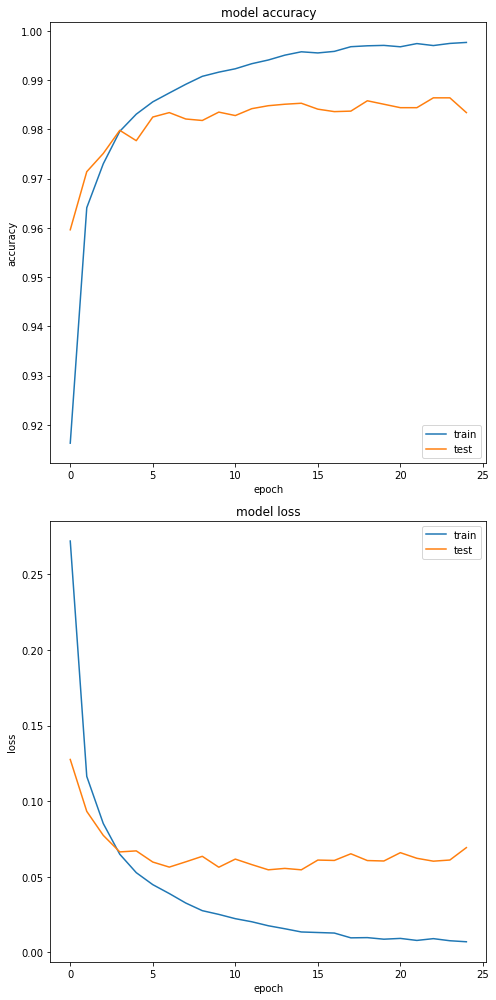

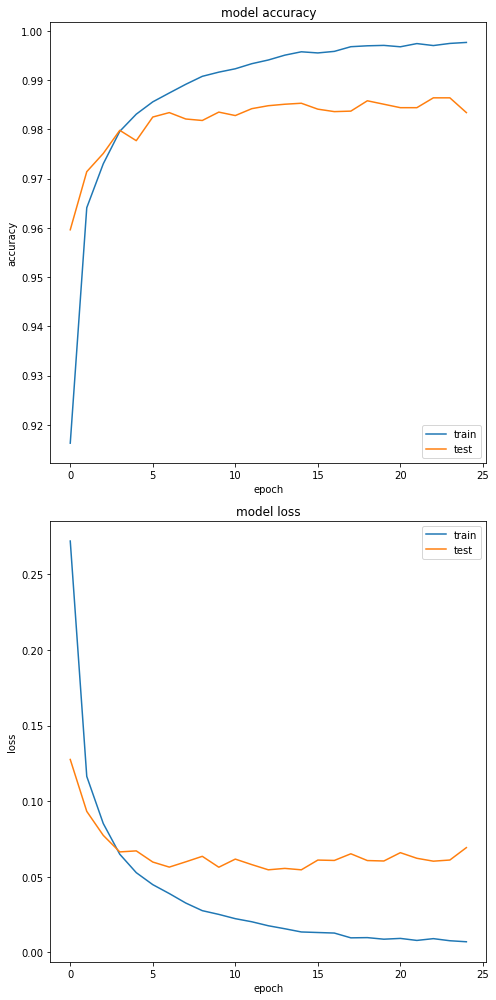

In [62]:
# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=25,
          verbose=2,
          validation_data=(X_test, Y_test))

# saving the model
save_dir = "/home/yerbolat/MOSIG/Semester2/Intelligent_Systems/results/"
model_name = 'keras_mnist_sgd.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [64]:
mnist_model = load_model('/home/yerbolat/MOSIG/Semester2/Intelligent_Systems/results/keras_mnist_sgd.h5')
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

Test Loss 0.06930627288505968
Test Accuracy 0.9833999872207642



9834  classified correctly
166  classified incorrectly


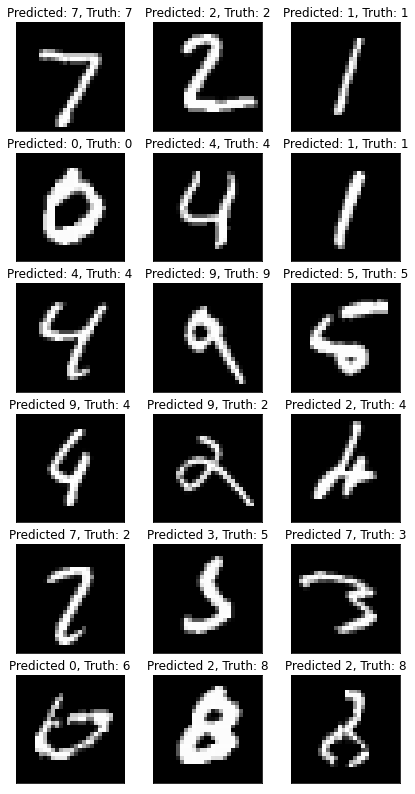

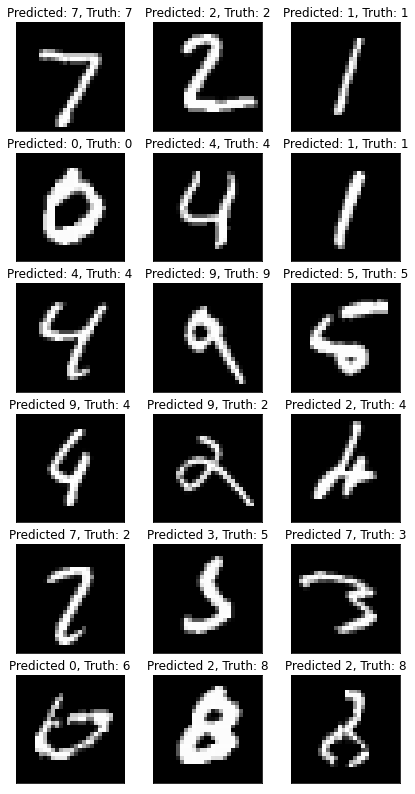

In [65]:
# load the model and create predictions on the test set
mnist_model = load_model('/home/yerbolat/MOSIG/Semester2/Intelligent_Systems/results/keras_mnist_sgd.h5')
predicted_classes = mnist_model.predict_classes(X_test)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

figure_evaluation

## Plotting ROC Curve

In [66]:
y_score = mnist_model.predict(X_test) 
print(y_score.shape)

(10000, 10)


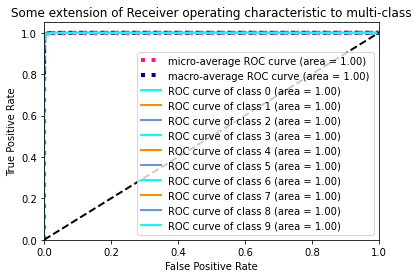

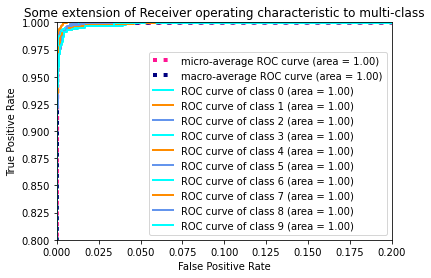

In [67]:
%matplotlib inline
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()



The average precision score

In [68]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


Plot the micro-averaged Precision-Recall curve

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=1.00')

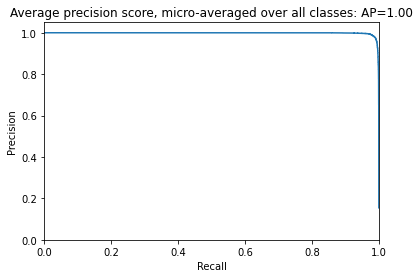

In [69]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))


Plot Precision-Recall curve for each class and iso-f1 curves

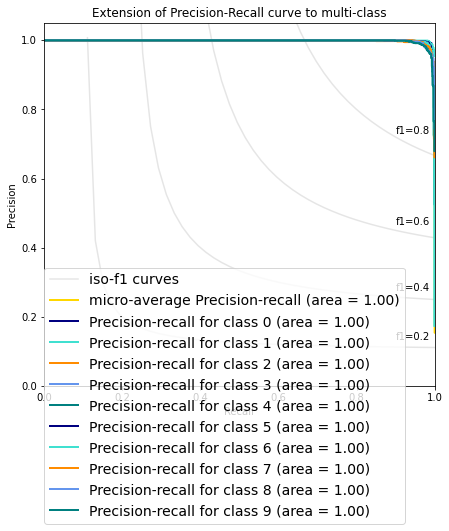

In [70]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()